# Week3 모두의 주차장 🚘

### 목적: 이용자 별 향후 한달간 이용건수 예측하기
- (Data) 이용자 별 결제 이력을 바탕으로 함
- (Task) Regression
- (Metric) MSE, MAE



Data Details
- 유저 가입 정보: id, 가입일
- 소비 행동 정보: 상품id, 점포 주소, 결제일, 결제건수
- 외부 정보: 서울시 지점별 교통량 데이터, 기온, 강수량, 풍속 등 기상 데이터


### 과제 제출에 포함되어야 하는 형태 (최소)
- 모델링에 대한 결과 .ipynb 파일
- .random.seed(42) 설정
- Input : X데이터 : [user_id, +@]
- Output : Count column 예측값
- 2020.01.01~2020.09.30 : Training Data
- 2020.10.01~2020.12.31 : Test Data
- 2020.10.01~2020.12.31 구간에 대한 MSE, MAE 계산값
- 요일별 이용량에 대한 분석 - EDA
- 유저별 이용 count 값에 대한 분석 - EDA

## 사전 준비

### 세팅

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('font', family="NanumGothic")

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#### ⭐과제 지시사항에 따라 random seed를42로 설정

In [2]:
np.random.seed(42)

### 데이터 로딩하기

#### 컬럼정보1(실전db.csv). 유저 가입 정보 및 소비 행동 정보
- USER_ID: 유저id
- JOIN_DATE: 가입일
- D_TYPE:
- STORE_ID: 상품id
- GOODS_TYPE:
- DATE: 결제일
- COUNT: 결제건수 ⭐ 예측해야하는 값(label)
- AD1: 점포 주소

In [3]:
data = pd.read_csv("실전db.csv", encoding="cp949")

print(data.shape)
data.head()

(879271, 8)


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


- D_TYPE, GOODS_TYPE, AD1 탐구 필요
- AD1의 경우, address로 추측되며, GN강남 J중구 SC서초 MP마포 등으로 추측할 수 있음

In [4]:
# 결측치 등 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


- NaN값은 없음
- 날짜 컬럼들(JOIN_DATE, DATE)이 object 형식 > 필요한 경우 변환해야 함

In [5]:
# 날짜 컬럼 일단 변환해줍니다.

data["DATE"] = pd.to_datetime(data["DATE"])
data["JOIN_DATE"] = pd.to_datetime(data["JOIN_DATE"])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   USER_ID     879271 non-null  int64         
 1   JOIN_DATE   879271 non-null  datetime64[ns]
 2   D_TYPE      879271 non-null  object        
 3   STORE_ID    879271 non-null  int64         
 4   GOODS_TYPE  879271 non-null  object        
 5   DATE        879271 non-null  datetime64[ns]
 6   COUNT       879271 non-null  int64         
 7   AD1         879271 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 53.7+ MB


#### AD1 컬럼 확인

In [6]:
print(data["AD1"].unique())
print(data["AD1"].nunique())

['GN' 'J' 'SC' 'MP' 'JRR' 'YD' 'GJ' 'YO' 'GSN' 'GBC' 'BF' 'DJ' '0' 'CD'
 'NO' 'CY' 'YC' 'SD' 'GD' 'GSW' 'DM' 'R' 'GB' 'GS' 'GHN' 'SB' 'IND' 'P'
 'GW' 'JR' 'GEJ' 'GGY' 'GKP' 'CAS' 'SG' 'BJG' 'BHW' 'GAY' 'GYI' 'CCA'
 'PJP' 'GGC' 'IYS' 'DB' 'GGM' 'GAS' 'WOID' 'DIV' 'AOI' 'COI' 'GPJ' 'SOI'
 'ABP' 'DOI' 'WF' 'BI' 'ZP' 'EP' 'Q' 'BO' 'ZE' 'RRR' 'QGI' 'DSO' 'SOD'
 'BOI' 'WT' 'BP' 'SP' 'CN' 'SJV' 'SDU' 'QH' 'BUD' 'CU' 'VU' 'WAE' 'NW'
 'DY' 'WH' 'GR' 'X' 'CVB' 'ADS' 'VO']
85


- 종로, 중구, 서초, 마포, 중랑, 영등포, 광진, 여의도 등 서울 '구'로 추정되는 이름들이 보임
- 이 지역정보를 알 수 있으면, 아래 traffic(교통량통합) 정보와 결합하여 사용 가능

#### 컬럼정보2(2020교통량통합.xlsx). 외부 정보: 서울시 지점별 교통량 데이터
- DATE
- 지점명
- 지점번호
- 방향
- 구분 
- 시간 

In [7]:
traffic = pd.read_excel("2020교통량통합.xlsx")

print(traffic.shape)
traffic.head()

(98820, 29)


,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,...,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,...,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,...,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0


유저 데이터에는 시간 구분이 없으므로, 트래픽 데이터에서도 구분 없이 일간 통행량을 체크합니다

In [8]:
traffic.columns

Index(['DATE', '지점명', '지점번호', '방향', '구분', '0시', '1시', '2시', '3시', '4시', '5시',
       '6시', '7시', '8시', '9시', '10시', '11시', '12시', '13시', '14시', '15시', '16시',
       '17시', '18시', '19시', '20시', '21시', '22시', '23시'],
      dtype='object')

In [9]:
traffic["traffic_total"] = traffic[['0시', '1시', '2시', '3시', '4시', '5시',
       '6시', '7시', '8시', '9시', '10시', '11시', '12시', '13시', '14시', '15시', '16시',
       '17시', '18시', '19시', '20시', '21시', '22시', '23시']].sum(axis=1)

traffic.head()

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,15시,16시,17시,18시,19시,20시,21시,22시,23시,traffic_total
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0,21513.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0,33156.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,...,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0,35143.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,...,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0,28899.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,...,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0,24003.0


지역명을 확인하기 전이기 때문에, 그냥 일단위 해당 지점, 방향을 고려하지 않은(전부 더한) 전체 총 통행량을 체크해보겠습니다.


In [10]:
daily_traffic = traffic.groupby("DATE")["DATE", 'traffic_total'].sum()

print(daily_traffic.shape)
daily_traffic.head()

(366, 1)


<ipython-input-10-413f62c0af24>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_traffic = traffic.groupby("DATE")["DATE", 'traffic_total'].sum()


,traffic_total
DATE,
2020-01-01,7347299.0
2020-01-02,9326734.0
2020-01-03,9998638.0
2020-01-04,9198233.0
2020-01-05,7868358.0


In [11]:
# 밑에서 병합해줄거라서 컬럼으로 빼줬습니다.
daily_traffic = daily_traffic.reset_index("DATE")

In [12]:
daily_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           366 non-null    datetime64[ns]
 1   traffic_total  366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


#### 컬럼정보3(서울시_기상데이터.csv). 외부 정보: 기상 데이터
- 지점:
- 일시:
- 기온:
- 강수량:
- 풍속:
- 습도:
- 일조시간:
- 적설량:
- 지면온도:
- 지중온도:

In [13]:
weather = pd.read_csv("서울시_기상데이터.csv", encoding="cp949")

print(weather.shape)
weather.head()

(8760, 10)


,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0


- (지점) 8760개의 데이터가 있는 것으로 보아, 지점은 단 1개만 있는 것으로 추청됨 (360 * 24 = 8760)
- (일시) 시간별 데이터이지만, 결합할 데이터가 일간 단위밖에 측정이 안되므로, 일단위로 맞춰줍니다.

In [14]:
# 지점 구분이 있는지 확인 (o)
weather["지점"].unique()

array([108], dtype=int64)

- 올바른 지점에서 관측된 것으로 간주하고, '지점'컬럼은 드롭합니다.

In [15]:
# 시간별 데이터 > 일간 데이터 (평균값)
weather["날짜"] = weather["일시"].astype(str).str[:10]
weather["날짜"] = pd.to_datetime(weather["날짜"])

daily_weather = weather.groupby("날짜").mean().drop("지점", axis=1)

print(daily_weather.shape) #2020년은 2월 29일이 있었으므로 366 row (o)
daily_weather.head()

(366, 8)


,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
날짜,,,,,,,,
2020-01-01,-2.543478,0.025,1.152174,62.739130,0.072727,0.0,-0.917391,2.856522
2020-01-02,0.987500,NaN,1.912500,64.875000,0.000000,NaN,-0.020833,2.625000
2020-01-03,0.120833,NaN,1.879167,57.833333,0.800000,NaN,-0.554167,2.683333
2020-01-04,1.054167,NaN,1.895833,50.875000,0.718182,NaN,-0.395833,2.695833
2020-01-05,1.175000,NaN,1.045833,45.666667,0.645455,NaN,-0.737500,2.629167


#### 위에서 체크한 3개의 서로 다른 데이터를 날짜로 묶어줍니다.

In [16]:
dtw = pd.merge(daily_traffic, daily_weather, left_on="DATE", right_on="날짜")

print(dtw.shape)
dtw.head()

(366, 10)


,DATE,traffic_total,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,2020-01-01,7347299.0,-2.543478,0.025,1.152174,62.739130,0.072727,0.0,-0.917391,2.856522
1,2020-01-02,9326734.0,0.987500,NaN,1.912500,64.875000,0.000000,NaN,-0.020833,2.625000
2,2020-01-03,9998638.0,0.120833,NaN,1.879167,57.833333,0.800000,NaN,-0.554167,2.683333
3,2020-01-04,9198233.0,1.054167,NaN,1.895833,50.875000,0.718182,NaN,-0.395833,2.695833
4,2020-01-05,7868358.0,1.175000,NaN,1.045833,45.666667,0.645455,NaN,-0.737500,2.629167


In [17]:
df = pd.merge(data, dtw, on="DATE")

print(df.shape)
df.head()

(879271, 17)


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,traffic_total,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522


- 전체 데이터를 병합한 데이터(일단위)

In [18]:
df.columns

Index(['USER_ID', 'JOIN_DATE', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 'DATE',
       'COUNT', 'AD1', 'traffic_total', '기온', '강수량', '풍속', '습도', '일조시간', '적설량',
       '지면온도', '지중온도'],
      dtype='object')

In [19]:
# 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879271 entries, 0 to 879270
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   USER_ID        879271 non-null  int64         
 1   JOIN_DATE      879271 non-null  datetime64[ns]
 2   D_TYPE         879271 non-null  object        
 3   STORE_ID       879271 non-null  int64         
 4   GOODS_TYPE     879271 non-null  object        
 5   DATE           879271 non-null  datetime64[ns]
 6   COUNT          879271 non-null  int64         
 7   AD1            879271 non-null  object        
 8   traffic_total  879271 non-null  float64       
 9   기온             879271 non-null  float64       
 10  강수량            357143 non-null  float64       
 11  풍속             879271 non-null  float64       
 12  습도             879271 non-null  float64       
 13  일조시간           876556 non-null  float64       
 14  적설량            27176 non-null   float64       
 15  

In [20]:
df["강수량"] = df["강수량"].fillna(0)
df["일조시간"] = df["일조시간"].fillna(0)
df["적설량"] = df["적설량"].fillna(0)

#### 📝과제 지시사항에 따라 10월1일을 기점으로 train 데이터와 test 데이터로 나눠줍니다

In [21]:
# train 데이터
train = df.loc[data["DATE"]<= "2020-09-30"]

print(train.shape)
train.head()

(623579, 17)


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,traffic_total,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522


In [22]:
# test 데이터
test = df.loc[data["DATE"]> "2020-09-30"]

print(test.shape)
test.head()

(255692, 17)


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,traffic_total,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
623579,15521,2014-09-12,AA,182320,A,2020-10-01,1,JRR,6879272.0,18.729167,0.0,2.158333,76.166667,0.192308,0.0,19.1875,21.3375
623580,17651,2014-09-19,BB,82434,D,2020-10-01,1,J,6879272.0,18.729167,0.0,2.158333,76.166667,0.192308,0.0,19.1875,21.3375
623581,26388,2014-10-25,BB,182320,A,2020-10-01,1,JRR,6879272.0,18.729167,0.0,2.158333,76.166667,0.192308,0.0,19.1875,21.3375
623582,81772,2015-05-02,BB,204438,A,2020-10-01,1,DJ,6879272.0,18.729167,0.0,2.158333,76.166667,0.192308,0.0,19.1875,21.3375
623583,92258,2015-05-24,AA,220745,A,2020-10-01,1,SD,6879272.0,18.729167,0.0,2.158333,76.166667,0.192308,0.0,19.1875,21.3375


In [23]:
train.describe()

,USER_ID,STORE_ID,COUNT,traffic_total,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
count,6.235790e+05,623579.000000,623579.000000,6.235790e+05,623579.000000,623579.000000,623579.000000,623579.000000,623579.000000,623579.000000,623579.000000,623579.000000
mean,1.160892e+06,148121.476666,1.027009,9.236243e+06,16.572184,0.457512,2.436875,65.382095,0.440531,0.022530,18.374687,17.347122
std,4.058201e+05,68859.988608,0.426268,8.362801e+05,9.178358,1.178613,0.731964,16.505519,0.311388,0.217441,9.831177,8.462887
min,2.240000e+02,4.000000,1.000000,6.116596e+06,-7.954167,0.000000,1.045833,17.875000,0.000000,0.000000,-3.041667,1.750000
25%,8.610140e+05,92403.000000,1.000000,8.915349e+06,9.125000,0.000000,1.912500,52.833333,0.120000,0.000000,11.195833,10.575000
50%,1.266192e+06,158176.000000,1.000000,9.463456e+06,20.062500,0.000000,2.200000,65.666667,0.491667,0.000000,21.650000,21.550000
75%,1.509012e+06,220655.000000,1.000000,9.832259e+06,24.308333,0.226667,2.845833,77.750000,0.738462,0.000000,26.275000,24.795833
max,1.709952e+06,230873.000000,49.000000,1.042626e+07,30.278261,8.900000,4.825000,96.541667,0.930769,3.187500,35.233333,27.812500


- (COUNT) 75% 이상은 1 : 한 번만 이용하는 경우가 대부분이라고 볼 수 있음
- (COUNT) 최소값이 1 : 실제 이용 한 경우만 카운트
- (COUNT) 최대값이 49 : 가장 이용 많이 한 유저를 찾아 해당 유저 데이터를 파보자

In [24]:
# 가장 많이 이용한 유저 찾기
train[train["COUNT"]== 49]

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,traffic_total,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
505902,999665,2018-12-16,CC,2428,A,2020-08-15,49,CY,8305884.0,26.1,3.631579,1.970833,95.625,0.0,0.0,26.2125,26.141667


In [25]:
# 49와 다음 숫자인 39 사이에 갭이 커서 어떤 기준인지 확인 어려움. 잘 모르겠으므로 시각화해서 확인
train[train["USER_ID"] == 999665].sort_values("COUNT", ascending=False).head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,traffic_total,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
505902,999665,2018-12-16,CC,2428,A,2020-08-15,49,CY,8305884.0,26.100000,3.631579,1.970833,95.625000,0.000000,0.0,26.212500,26.141667
371177,999665,2018-12-16,CC,2058,A,2020-06-27,39,GN,9465922.0,23.941667,0.000000,1.933333,69.791667,0.493333,0.0,25.258333,23.658333
591734,999665,2018-12-16,CC,90542,A,2020-09-19,39,GN,8566903.0,21.283333,0.100000,2.266667,60.083333,0.746154,0.0,21.712500,23.104167
605474,999665,2018-12-16,CC,223666,A,2020-09-24,39,SJV,9220039.0,20.654167,0.000000,3.570833,59.291667,0.615385,0.0,22.395833,22.145833
611928,999665,2018-12-16,CC,220959,A,2020-09-26,38,SC,8715755.0,19.341667,0.000000,2.475000,62.333333,0.615385,0.0,20.462500,21.975000


<AxesSubplot:xlabel='DATE', ylabel='COUNT'>

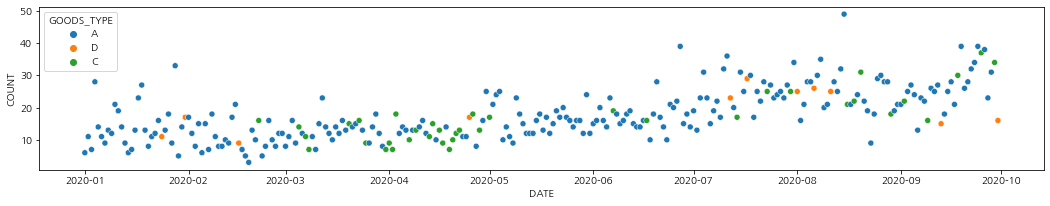

In [26]:
# 더 모르겠음...
plt.figure(figsize = (18,3))
sns.scatterplot(data=train[train["USER_ID"] == 999665], x="DATE", y="COUNT", hue="GOODS_TYPE")

# 가설
- (요일:DATE) 주중 & 주말 사용량이 달라 영향을 미칠 것
- (연휴:DATE) 주말과 같은 이유. holidays 컬럼을 생성해서 확인해도 좋을 것
- (최근이용일:DATE) 가장 최근 이용한 날짜가 너무 예전이면 이용하지 않을 것
- (지역:STORE_ID,AD1) 주차장이 정말 필요한 곳
- (날씨:기온,강수량,풍속,습도) 대중교통 이용하기 어려운 날 이용률 높을 것
- (교통량): 교통량이 많은 날 이용률이 높을 것


# 요일별 이용량에 대한 분석 - EDA ⭐

In [27]:
# 날짜데이터의 Datetime화
data['JOIN_DATE']=pd.to_datetime(data['JOIN_DATE'],format='%Y-%m-%d')
data['DATE']=pd.to_datetime(data['DATE'],format='%Y-%m-%d')

print(data.shape)
data.info()

(879271, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   USER_ID     879271 non-null  int64         
 1   JOIN_DATE   879271 non-null  datetime64[ns]
 2   D_TYPE      879271 non-null  object        
 3   STORE_ID    879271 non-null  int64         
 4   GOODS_TYPE  879271 non-null  object        
 5   DATE        879271 non-null  datetime64[ns]
 6   COUNT       879271 non-null  int64         
 7   AD1         879271 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 53.7+ MB


In [28]:
# 요일 컬럼을 추가해줍니다.
data['DAY'] = data['DATE'].dt.weekday

print(data.shape)
data.sort_values(by="USER_ID").head() #요일이 잘 들어갔는지 확인

(879271, 9)


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,DAY
821958,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2
18802,224,2013-12-16,AA,92510,A,2020-01-12,1,J,6
763324,232,2013-12-17,BB,173268,A,2020-11-18,1,J,2
429676,232,2013-12-17,BB,28018,C,2020-07-19,1,JRR,6
242831,232,2013-12-17,BB,28018,C,2020-05-05,1,JRR,1


<AxesSubplot:xlabel='DAY', ylabel='count'>

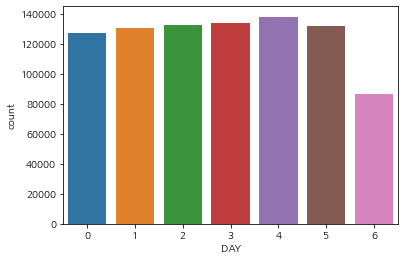

In [29]:
sns.countplot(data=data, x="DAY") #월요일이0, 일요일이6

# 일요일이 확실히 이용건수가 줄었네요

<AxesSubplot:xlabel='DAY', ylabel='count'>

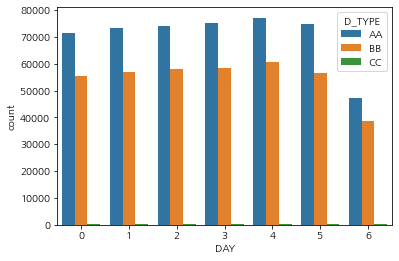

In [30]:
sns.countplot(data=data, x="DAY", hue="D_TYPE")

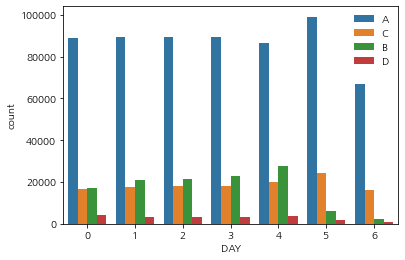

In [31]:
sns.countplot(data=data, x="DAY", hue="GOODS_TYPE").legend(frameon=False)

- A가 이용률이 압도적으로 많고, D가 이용률이 압도적으로 적음
- A는 오히려 토요일에 이용 증가, 일요일에 감소
- B는 월금 이용 증가, 토~일에 감소
- C는 월~토 이용 증가, 일요일에 감소

# 유저별 이용 count 값에 대한 분석 - EDA ⭐

# Train

  * **X_train**: train 데이터의 feature
  * **X_test**: test 데이터의 feature다.
  * **y_train**: train 데이터의 label
  * **y_predict**: test 데이터의 label

In [39]:
# feature로 넣을 변수들을 넣어줍시다
feature_names = ['USER_ID', 'STORE_ID',
       'traffic_total', '기온', '강수량', '풍속', '습도', '일조시간', '적설량',
       '지면온도', '지중온도']
feature_names

['USER_ID',
 'STORE_ID',
 'traffic_total',
 '기온',
 '강수량',
 '풍속',
 '습도',
 '일조시간',
 '적설량',
 '지면온도',
 '지중온도']

In [40]:
# train 데이터의 feature를 가져옵니다
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(623579, 11)


,USER_ID,STORE_ID,traffic_total,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,2858,1892,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
1,5647,182009,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
2,33314,82431,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
3,37001,725,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522
4,37819,220691,7347299.0,-2.543478,0.025,1.152174,62.73913,0.072727,0.0,-0.917391,2.856522


In [41]:
# test 데이터의 feature를 가져옵니다
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(255692, 11)


,USER_ID,STORE_ID,traffic_total,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
623579,15521,182320,6879272.0,18.729167,0.0,2.158333,76.166667,0.192308,0.0,19.1875,21.3375
623580,17651,82434,6879272.0,18.729167,0.0,2.158333,76.166667,0.192308,0.0,19.1875,21.3375
623581,26388,182320,6879272.0,18.729167,0.0,2.158333,76.166667,0.192308,0.0,19.1875,21.3375
623582,81772,204438,6879272.0,18.729167,0.0,2.158333,76.166667,0.192308,0.0,19.1875,21.3375
623583,92258,220745,6879272.0,18.729167,0.0,2.158333,76.166667,0.192308,0.0,19.1875,21.3375


In [42]:
# train 데이터의 label을 가져옵니다
y_train = train["COUNT"]

print(y_train.shape)
y_train.head()

(623579,)


0    1
1    1
2    1
3    1
4    1
Name: COUNT, dtype: int64

In [43]:
# test 데이터의 label을 가져옵니다 (맞혀야하는 실제 정답 값)
y_test = test["COUNT"]

print(y_test.shape)
y_test.head()

(255692,)


623579    1
623580    1
623581    1
623582    1
623583    1
Name: COUNT, dtype: int64

### Use Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=10,
                              n_jobs=-1)
model

RandomForestRegressor(n_estimators=10, n_jobs=-1)

### Fit

In [45]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1)

### Predict

In [46]:
# 맞히려는 값의 예측 값 ⭐
y_predict = model.predict(X_test)

print(y_predict.shape)
y_predict

(255692,)


array([1.1, 1.1, 1.1, ..., 1.1, 1.2, 1. ])

# Evaluation 1)MAE ⭐

In [49]:
MAE = mean_absolute_error(y_test, y_predict)

MAE

0.08405307948625693

# Evaluation 2)MSE ⭐

In [50]:
MSE = mean_squared_error(y_test, y_predict)

MSE

0.23487848661671068